### PART B: Build a machine learning model to classify customer reviews as positive or negative. This is a basic text classification problem. The candidate will demonstrate skills in text preprocessing, feature extraction, and training a simple ML model. (30 marks)

## Required Library 

In [212]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')



In [213]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...


True

## 1) Data Collection

In [215]:
df = pd.read_csv("./IMDB Dataset.csv")
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [216]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [217]:
df.duplicated().sum()

418

In [218]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [219]:
df = df.drop_duplicates()

In [220]:
df.shape

(49582, 2)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


<Axes: xlabel='sentiment', ylabel='count'>

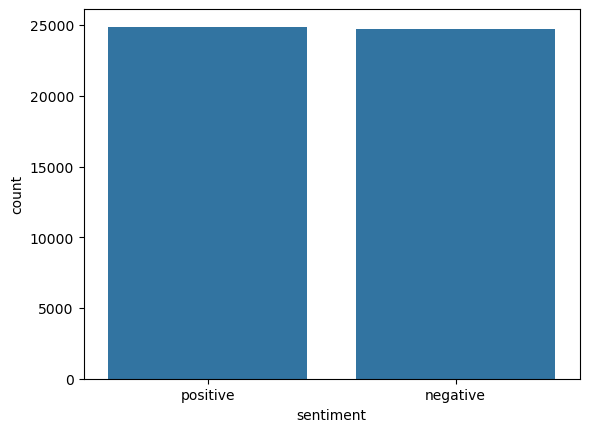

In [222]:
sns.countplot(data=df, x='sentiment')

In [223]:
def textPreprocess(feature):
    cleaned_text = []
    for review in tqdm(feature):
        review = re.sub('[^A-Za-z0-9:)()]+', ' ', review)
        review = review.lower()
        cleaned_text.append(review)
    return(cleaned_text)

In [224]:
clean_text_corpus = textPreprocess(df['review'])
df['cleaned_review'] = clean_text_corpus

100%|████████████████████████████████████████████████████████████████████████████████████| 49582/49582 [00:07<00:00, 6464.10it/s]


In [225]:
df.head(3)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...


In [226]:
df1 = df.drop(columns=['review'])

In [227]:
df1.head(3)

,sentiment,cleaned_review
0,positive,one of the other reviewers has mentioned that ...
1,positive,a wonderful little production br br the filmin...
2,positive,i thought this was a wonderful way to spend ti...


In [228]:
df1['sentiment'] = df1['sentiment'].map({'positive':1, 'negative':0}) 

In [229]:
df1.head(3)

,sentiment,cleaned_review
0,1,one of the other reviewers has mentioned that ...
1,1,a wonderful little production br br the filmin...
2,1,i thought this was a wonderful way to spend ti...


In [230]:
# Print some of the stop words to get some idea
english_stopwords = stopwords.words('english')
' '.join(english_stopwords)

"a about above after again against ain all am an and any are aren aren't as at be because been before being below between both but by can couldn couldn't d did didn didn't do does doesn doesn't doing don don't down during each few for from further had hadn hadn't has hasn hasn't have haven haven't having he he'd he'll her here hers herself he's him himself his how i i'd if i'll i'm in into is isn isn't it it'd it'll it's its itself i've just ll m ma me mightn mightn't more most mustn mustn't my myself needn needn't no nor not now o of off on once only or other our ours ourselves out over own re s same shan shan't she she'd she'll she's should shouldn shouldn't should've so some such t than that that'll the their theirs them themselves then there these they they'd they'll they're they've this those through to too under until up ve very was wasn wasn't we we'd we'll we're were weren weren't we've what when where which while who whom why will with won won't wouldn wouldn't y you you'd you

In [231]:
# Instantiate the stemmer which is used for word lemmitization
# stemmer  = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()
def tokenizer(text):
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

In [232]:
# Initialize the TfIdf vectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizer, #to tokenize the sentences and do stemming
                             stop_words=english_stopwords, #provide the stopwords to be removed
                             ngram_range=(1, 2), # here we conider both un-grams and bi-grams (for combination of words ex 'I love')
                             max_features=2500 # length of the vocabulary
                             )

In [233]:
vectorizer.fit(df1['cleaned_review'])

TfidfVectorizer(max_features=2500, ngram_range=(1, 2),
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenizer at 0x0000028B89FD8FE0>)

In [234]:
from sklearn.model_selection import train_test_split
x = df1['cleaned_review']
y = df1['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [235]:
# Apply the trained vectorizer to the train and test data
train_inputs = vectorizer.transform(x_train)
test_inputs = vectorizer.transform(x_test)

In [236]:
print(f"Total number of terms in the vocabulary: {len(vectorizer.vocabulary_)}")

Total number of terms in the vocabulary: 2500


In [237]:
vectorizer.get_feature_names_out()[:200] #no stop words or any other non required characters

array(['(', '( )', '( although', '( especially', '( even', '( like',
       '( one', '( played', '( wa', ')', ') :', ') also', ') br',
       ') film', ') get', ') ha', ') movie', ') one', ') wa', '0', '000',
       '1', '1 10', '1 2', '10', '10 10', '10 br', '100', '11', '12',
       '13', '15', '2', '2 )', '20', '3', '3 10', '30', '4', '4 10', '40',
       '5', '50', '6', '60', '7', '7 10', '70', '8', '8 10', '80', '9',
       '9 10', '90', '90 minute', ':', ': )', ': br', 'ability', 'able',
       'absolute', 'absolutely', 'absurd', 'academy', 'accent', 'accept',
       'accident', 'according', 'account', 'accurate', 'across', 'act',
       'acted', 'acting', 'acting wa', 'action', 'action movie',
       'action scene', 'actor', 'actress', 'actual', 'actually', 'adam',
       'adaptation', 'add', 'added', 'addition', 'admit', 'adult',
       'adventure', 'advice', 'affair', 'afraid', 'african', 'age',
       'aged', 'agent', 'ago', 'agree', 'ahead', 'air', 'al', 'alan',
       'albe

In [238]:
# Note that each input is represented w.r.t the length of the vocabulary
train_inputs.shape

(39665, 2500)

In [239]:
train_inputs.toarray() # input is till sparse, the number represents the TFIDF for each term

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09545606, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07064251, 0.        , 0.        , ..., 0.08076791, 0.        ,
        0.        ],
       ...,
       [0.05574566, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [240]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression() #Initialize the model with default parameters
log_reg_model.fit(train_inputs, y_train) # Train the model

LogisticRegression()

In [241]:
y_preds = log_reg_model.predict(test_inputs) # predict the results

In [242]:
train_score = log_reg_model.score(train_inputs, y_train)
test_score = log_reg_model.score(test_inputs, y_test)

print(f"Train Accuracy: {train_score:.2f}")
print(f"Test Accuracy: {test_score:.2f}")


Train Accuracy: 0.91
Test Accuracy: 0.89


In [243]:
test_accuracy = accuracy_score(y_preds, y_test)

print(test_accuracy)

0.8871634566905314


In [244]:
# Print the classification report
# print(log_reg_model.score(y_preds, y_test))
print(classification_report(y_preds, y_test))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4804
           1       0.90      0.88      0.89      5113

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



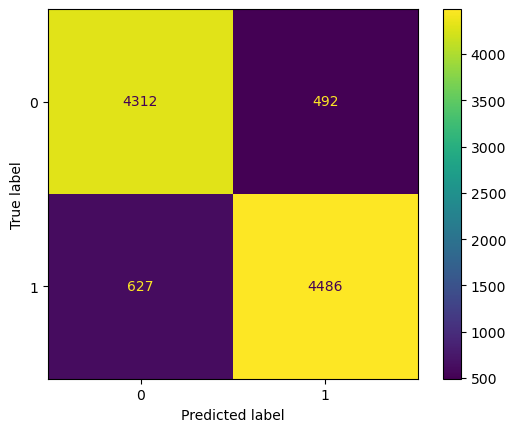

In [245]:
# Display the confusion matrix
cm = confusion_matrix(y_preds, y_test, labels=log_reg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg_model.classes_)
disp.plot()
plt.show()

In [349]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Compatible solvers for L1/L2
}

# Initialize the model
log_reg = LogisticRegression(max_iter=1000)

# Perform Grid Search with 5-fold Cross Validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_inputs, y_train)

# Print the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train the final model using the best parameters
best_log_reg = grid_search.best_estimator_

# Evaluate on the test set
y_preds = best_log_reg.predict(test_inputs)

# Print accuracy
print(f"Test Accuracy: {accuracy_score(y_test, y_preds):.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_preds))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [246]:
# # Train and predict RandomForest classifier
# param_grid = {'n_estimators': [100, 200, 500], # Build the parameter grid
#               'max_depth': [None, 5, 10, 15],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4]}
# rfc = RandomForestClassifier(random_state=0, verbose=True) # Initialize the model
# rfc_grid_search = RandomizedSearchCV(rfc, param_distributions=param_grid, cv=5, n_iter=15) # Initialise the Randomised search CV
# rfc_grid_search.fit(train_inputs[0:2000], y_train[:2000]) # Fit the Randomise search CV for sample data

In [247]:
# rfc_best_model = rfc_grid_search.best_estimator_ # get the best model with best hyperparameter
# rfc_best_model.fit(train_inputs, y_train) # train the model on train data
# rfc_ypreds = rfc_best_model.predict(test_inputs) # predict the results
# rfc_accuracy_score = accuracy_score(rfc_ypreds, y_test) # get the accuracy score
# print(f"Accuracy of Randdom Forest Classifier is {rfc_accuracy_score}")

In [248]:
# # print precision, accuracy, recall and f1-score for Randomforest classifer
# print(classification_report(rfc_ypreds, y_test))

Text(0, 0.5, 'Accuracy in %')

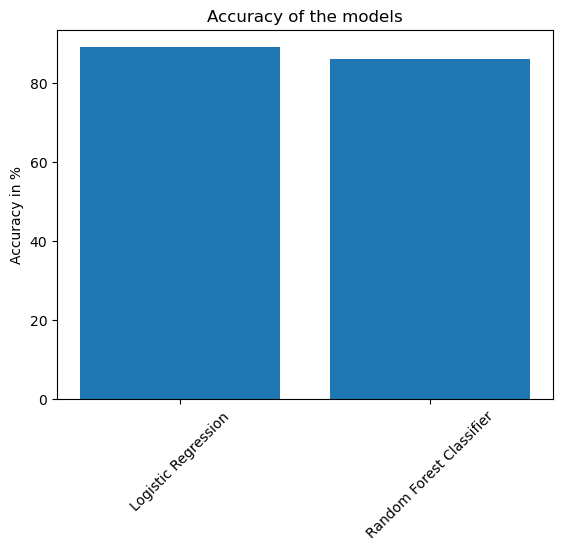

In [249]:

# Plot the accuracy of the models
models = ['Logistic Regression', 'Random Forest Classifier']
accuracy = [test_score, 86]
plt.bar(models, accuracy)
plt.xticks(rotation=45);
plt.title('Accuracy of the models')
plt.ylabel('Accuracy in %')

In [346]:
def predict_sentiment(text, vectorizer, model):
    # Preprocess the text (cleaning)
    text = re.sub('[^A-Za-z0-9:)()]+', ' ', text).lower()
    
    # Convert text to TF-IDF features
    text_vector = vectorizer.transform([text])  # Transform into TF-IDF vector

    # Get the prediction (0 = Negative, 1 = Positive)
    prediction = model.predict(text_vector)[0]

    # human-readable output
    sentiment = "Positive 😊" if prediction == 1 else "Negative 😞"

    return sentiment

# Example Usage
sample_text = "This movie was absolutely fantastic! I loved it"
result = predict_sentiment(sample_text, vectorizer, log_reg_model)
print(f"Predicted Sentiment: {result}")


Predicted Sentiment: Positive 😊


In [350]:
import pickle

# Save vectorizer
with open("TFIDF_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save Logistic Regression model
with open("logistic_regression_model.pkl", "wb") as f:
    pickle.dump(log_reg_model, f)
